# Towards Petascale Postprocessing with Python #
 
Climate models blah blah blah...
 

<video class="asset-video" width="100%"
height="auto" poster="https://svs.gsfc.nasa.gov/vis/a030000/a030500/a030552/Globe-00000001_print.jpg"
controls="controls" preload="none">
<!-- MP4 for Safari, IE9, iPhone, iPad, Android, and Windows Phone 7 -->
<!-- movie assets *high.mp4 -->
<!-- movie assets *other movie type that works with Chrome* -->
<source type="video/mp4" src="https://svs.gsfc.nasa.gov/vis/a030000/a030500/a030552/ecco_sea_surface_speed_globe_720p.mp4" />
<!-- WebM/VP8 for Firefox4, Opera, and Chrome --> 
<source type="video/webm" src="https://svs.gsfc.nasa.gov/vis/a030000/a030500/a030552/ecco_sea_surface_speed_globe_720p.webm" /> 
<!-- Flash fallback for non-HTML5 browsers without JavaScript -->
  <object width="100%" height="auto" type="application/x-shockwave-flash"
  data="https://svs.gsfc.nasa.gov/loop/flashmediaelement.swf">
    <param name="movie" value="https://svs.gsfc.nasa.gov/loop/flashmediaelement.swf">
<!-- movie assets *high.mp4 -->
    <param name="flashvars" value="controls=true&amp;poster=myvideo.jpg&amp;file=https://svs.gsfc.nasa.gov/vis/a030000/a030500/a030552/ecco_sea_surface_speed_globe_720p.mp4">
    <!-- Image as a last resort -->
<!-- movie assets poster frame -->
    <img src="https://svs.gsfc.nasa.gov/vis/a030000/a030500/a030552/Globe-00000001_print.jpg" width="100%" height="auto" title="No video playback capabilities" style=""> 
  </object>
</video>

Video Credit: [NASA/JPL-Caltech via NASA Scientific Visualization Studio](https://svs.gsfc.nasa.gov/30552)

## xarray
![xarray](http://xarray.pydata.org/en/stable/_images/dataset-diagram-logo.png)

## dask
![dask](http://dask.readthedocs.io/en/latest/_images/collections-schedulers.png)

In [6]:
import xgcm
import xmitgcm
import xrft
import numpy as np
import os
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
from dask.utils import SerializableLock
from dask.distributed import Client
scheduler_file = '../.dask_scheduler/dask_scheduler_file-' + os.environ['SLURM_JOBID']
client = Client(scheduler_file=scheduler_file)
client

<Client: scheduler='tcp://10.43.4.184:8786' processes=1 cores=48>

In [4]:
ddir = '/rigel/ocp/users/ra2697/channel_topography/GCM/run_taux2000_rb0110_bump'
ds = xmitgcm.open_mdsdataset(ddir, prefix=['U', 'Eta', 'T', 'V', 'S', 'W'])#, prefix=['Diag_ThPhUVW'], iters=iters)
ds

/rigel/home/ra2697/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)


<xarray.Dataset>
Dimensions:              (XC: 400, XG: 400, YC: 400, YG: 400, Z: 40, Zl: 40, Zp1: 41, Zu: 40, layer_1TH_bounds: 43, layer_1TH_center: 42, layer_1TH_interface: 41, time: 1566)
Coordinates:
  * XC                   (XC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 ...
  * YG                   (YG) >f4 0.0 5000.0 10000.0 15000.0 20000.0 25000.0 ...
  * YC                   (YC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 ...
  * XG                   (XG) >f4 0.0 5000.0 10000.0 15000.0 20000.0 25000.0 ...
  * Zp1                  (Zp1) float32 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 ...
  * Z                    (Z) float32 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 ...
  * Zl                   (Zl) float32 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 ...
  * Zu                   (Zu) float32 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 ...
    dxC                  (YC, XG) >f4 5000.0 5000.0 5000.0 5000.0 5000.0 ...
    rAw                  (YC, XG) >f4 2.5e+07 2.5e+07 2.5e+07 2.5e+07 ...
    dyG                

In [10]:
ds.W.nbytes / 1e9

40.0896

In [5]:
w_sq_profile = (ds.W**2).mean(dim=('time', 'YC', 'XC'))
w_sq_profile

<xarray.DataArray 'W' (Zl: 40)>
dask.array<mean_ag..., shape=(40,), dtype=float32, chunksize=(40,)>
Coordinates:
  * Zl       (Zl) float32 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 ...

CPU times: user 1 s, sys: 21.7 ms, total: 1.02 s
Wall time: 1min 40s


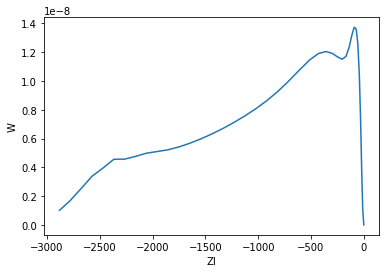

In [6]:
%time w_sq_profile.plot()

In [7]:
v_fft = xrft.dft(ds.V, dim=['XC'], shift=False)
pow_spec = (v_fft*v_fft.conj()).isel(freq_XC=slice(0,len(ds.XC)//2)).mean(dim=('YG','time')).astype('f8')
pow_spec

/rigel/home/ra2697/miniconda/envs/dask_distributed/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: pandas.core.common.is_timedelta64_dtype is deprecated. import from the public API: pandas.api.types.is_timedelta64_dtype instead
  if __name__ == '__main__':
/rigel/home/ra2697/miniconda/envs/dask_distributed/lib/python3.5/site-packages/dask/array/core.py:465: RuntimeWarning: invalid value encountered in multiply
  o = func(*args, **kwargs)


<xarray.DataArray 'fft-410561025a9f1bfb70d9b8aae09a51a9' (Z: 40, freq_XC: 200)>
dask.array<astype-..., shape=(40, 200), dtype=float64, chunksize=(40, 200)>
Coordinates:
  * freq_XC          (freq_XC) float64 0.0 5e-07 1e-06 1.5e-06 2e-06 2.5e-06 ...
    freq_XC_spacing  float64 5e-07
  * Z                (Z) float32 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 ...

In [8]:
%time pow_spec.load()

CPU times: user 1.92 s, sys: 57.9 ms, total: 1.98 s
Wall time: 1min 58s


<xarray.DataArray 'fft-410561025a9f1bfb70d9b8aae09a51a9' (Z: 40, freq_XC: 200)>
array([[  1.617059e-12,   4.936453e+01,   1.782412e+02, ...,   1.163677e-02,
          1.159787e-02,   1.156620e-02],
       [  1.292125e-12,   4.942939e+01,   1.780007e+02, ...,   1.103896e-02,
          1.100254e-02,   1.097060e-02],
       [  1.058217e-12,   5.095904e+01,   1.793554e+02, ...,   9.761774e-03,
          9.733705e-03,   9.699409e-03],
       ..., 
       [  4.797007e-14,   8.443024e+00,   2.487334e+01, ...,   9.976562e-04,
          8.473423e-04,   7.365751e-04],
       [  4.760242e-14,   8.701984e+00,   2.503824e+01, ...,   5.400265e-04,
          5.158379e-04,   4.927150e-04],
       [  4.953190e-14,   8.772978e+00,   2.426434e+01, ...,   3.297407e-04,
          3.298144e-04,   3.300105e-04]])
Coordinates:
  * freq_XC          (freq_XC) float64 0.0 5e-07 1e-06 1.5e-06 2e-06 2.5e-06 ...
    freq_XC_spacing  float64 5e-07
  * Z                (Z) float32 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -

(0.01, 1000.0)

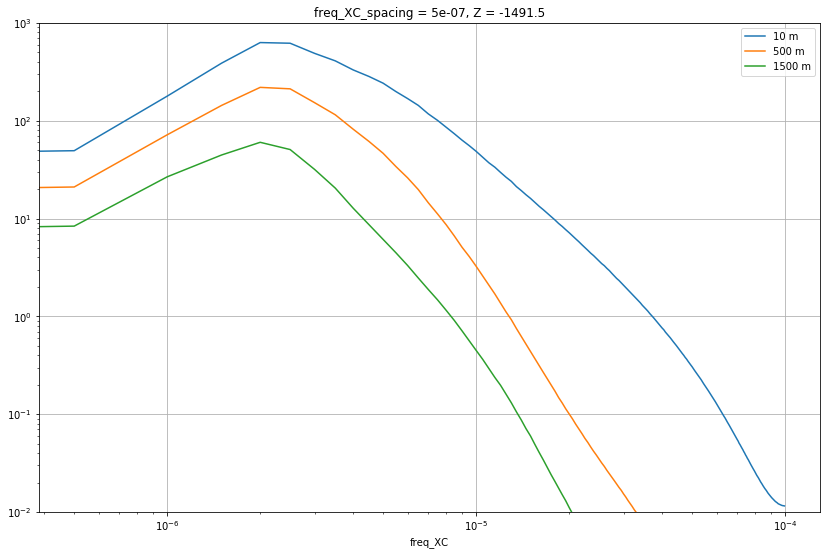

In [9]:
fig, ax = plt.subplots(figsize=(14,9))
pow_spec.sel(Z=-10, method='nearest').plot(ax=ax, label='10 m')
pow_spec.sel(Z=-500, method='nearest').plot(ax=ax, label='500 m')
pow_spec.sel(Z=-1500, method='nearest').plot(ax=ax, label='1500 m')
ax.legend()
ax.grid()
ax.set_xscale('log')
ax.set_ylabel('')
ax.set_yscale('log')
ax.set_ylim([1e-2,1e3])

In [72]:
from dask.dot import dot_graph

RuntimeError: Drawing dask graphs requires the `graphviz` python library and the `graphviz` system library to be installed.